### Initialization
Just ignore this section!

In [1]:
import sys, os
sys.path.append(os.getenv('VIRTUAL_ENV')+'/lib/python3.8/site-packages/')
import curves as c
import matplotlib.pyplot as plt
pc=1e-2
year = 1
month = year/12
day = month/30
week = 7*day

In [2]:
def add_eur_libor_quotes_1(curve):
    # https://www.global-rates.com/en/interest-rates/libor/libor.aspx
    
    # date: 06-25-2021
    data = [
        {'t0':0, 'length': 1*day,   'rate': -0.58471*pc},
        {'t0':0, 'length': 1*week,  'rate': -0.57571*pc},
        {'t0':0, 'length': 1*month, 'rate': -0.57786*pc},
        {'t0':0, 'length': 2*month, 'rate': -0.55857*pc},
        {'t0':0, 'length': 3*month, 'rate': -0.54614*pc},
        {'t0':0, 'length': 6*month, 'rate': -0.52614*pc},
        {'t0':0, 'length': 1*year,  'rate': -0.48357*pc},
    ]
    for v in data:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [3]:
def add_eur_libor_quotes_2(curve):
    # https://www.chathamfinancial.com/technology/european-market-rates
    
    # date: 06-25-2021
    data = [
        {'t0':0, 'length': 1*month, 'rate': -0.56200*pc},
        {'t0':0, 'length': 3*month, 'rate': -0.53800*pc},
        {'t0':0, 'length': 6*month, 'rate': -0.51300*pc},
        {'t0':0, 'length': 1*year,  'rate': -0.47800*pc},
    ]
    for v in data:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [4]:
def add_fras(curve):
    libor_quotes = [
        {'t0': 0, 'length': 1*month, 'rate':-0.553*pc},
        {'t0': 0, 'length': 3*month, 'rate':-0.540*pc},
        {'t0': 0, 'length': 6*month, 'rate':-0.508*pc},
        {'t0': 0, 'length': 1*year,  'rate':-0.477*pc},
    ]
    for v in libor_quotes:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [5]:
def add_swaps(curve,curve_float_leg=None):
    if curve_float_leg is None:
        curve_float_leg = curve
    t0 = 0
    dt = year*0.25
    swaps = {
         1*year:  0.19*pc,
         2*year:  0.32*pc,
         3*year:  0.55*pc,
         5*year:  0.93*pc,
         7*year:  1.20*pc,
        10*year:  1.45*pc,
        15*year:  1.53*pc,
        30*year:  1.78*pc
    }
    for period,rate in swaps.items():

        swap = c.Swap()

        # fixed rate: payed quartely
        swap.lfix = c.LegFixed(t0,dt,round(period/dt),rate)

        # floating rate: payed quartely
        dt = year*0.25

        swap.lflt = c.LegFloat(t0,dt,round(period/dt),curve_float_leg)
        curve.Add(swap)


# Single Curve construction
Construct a single curve from a set of instruyments with Linear an Cubic interpolations.

In [6]:
libor_curve_linear = c.Curve()
libor_curve_cspline = c.Curve()
add_eur_libor_quotes_2(libor_curve_linear)
add_eur_libor_quotes_2(libor_curve_cspline)
libor_curve_linear.Build(c.Interpolator1D.Type.Linear)
libor_curve_cspline.Build(c.Interpolator1D.Type.CubicSpline)

value=3.44777e-12 error=nan code=0 error="" x=[-0.00249409,-0.00783417,-0.00141522,-0.0109821,0.0128189,]

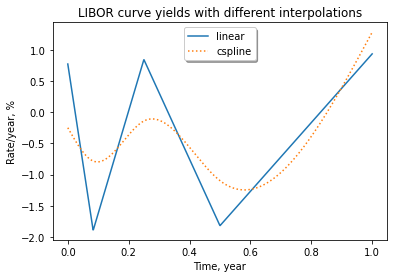

In [7]:
points=1000
tmax=1
vx = []
vy1 = []
vy2 = []
#     tmax = list(yc.GetYields().keys())[-1].GetYearFraction()
for i in range(points):
    t = (tmax*i)/(points-1)
    vx.append(t)
    vy1.append(libor_curve_linear(t)/pc)
    vy2.append(libor_curve_cspline(t)/pc)
fig, ax = plt.subplots()
ax.set_xlabel('Time, year')
ax.set_ylabel('Rate/year, %')
ax.plot(vx,vy1,'-',label='linear')
ax.plot(vx,vy2,':',label='cspline')
ax.legend(loc='upper center', shadow=True)
plt.title('LIBOR curve yields with different interpolations')
plt.show()


## Pricing a single instrument

In [8]:
fra1 = c.ForwardRateAgreement(0,1*month,-0.553*pc)
fra1.Eval(libor_curve_linear)

-0.005619163624942303

# Show the forward rates

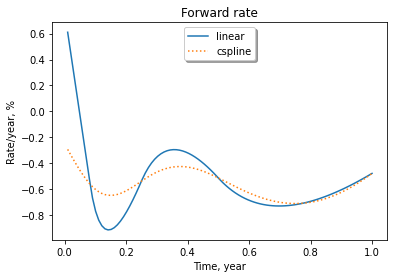

In [9]:
points=100
tmax=1
vx = []
vy1 = []
vy2 = []
#     tmax = list(yc.GetYields().keys())[-1].GetYearFraction()
for i in range(points):
    t = (tmax*i)/(points-1)
    vx.append(t)
    vy1.append(libor_curve_linear.GetForwardRate(0,t)/pc)
    vy2.append(libor_curve_cspline.GetForwardRate(0,t)/pc)
fig, ax = plt.subplots()
ax.set_xlabel('Time, year')
ax.set_ylabel('Rate/year, %')
ax.plot(vx,vy1,'-',label='linear')
ax.plot(vx,vy2,':',label='cspline')
ax.legend(loc='upper center', shadow=True)
plt.title('Forward rate')
plt.show()


# Curve construction with swaps (using single curve approach)

In [10]:
curve_single = c.Curve()
add_swaps(curve_single)
curve_single.Build() # use cubic interpolation by default

value=4.70392e-07 error=nan code=0 error="" x=[-0.00786109,0.00742854,0.0036223,0.0164896,0.0110241,0.0283865,0.00793355,0.0389126,-0.0567328,]

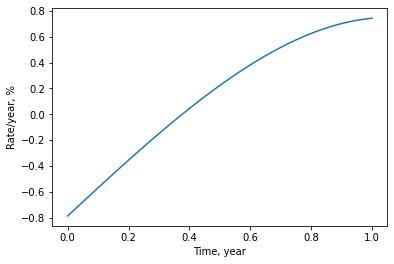

In [11]:
points=100
tmax=1
vx = []
vy1 = []
for i in range(points):
    t = (tmax*i)/(points-1)
    vx.append(t)
    vy1.append(curve_single(t)/pc)
fig, ax = plt.subplots()
ax.set_xlabel('Time, year')
ax.set_ylabel('Rate/year, %')
ax.plot(vx,vy1,'-')
plt.show()


# Real data example

In [12]:
true=True
data1 = [{"type":"FRA","use":true,"start":0,"length":1,"quote":-0.371},{"type":"FRA","use":true,"start":0,"length":6,"quote":-0.278},{"type":"FRA","use":true,"start":0,"length":12,"quote":-0.191}]
data2 = [{"type":"FRA","use":true,"start":0,"length":1,"quote":-0.371},{"type":"FRA","use":true,"start":0,"length":2,"quote":-0.341},{"type":"FRA","use":true,"start":0,"length":3,"quote":-0.329},{"type":"FRA","use":true,"start":0,"length":6,"quote":-0.278},{"type":"FRA","use":true,"start":0,"length":9,"quote":-0.222},{"type":"FRA","use":true,"start":0,"length":12,"quote":-0.191},{"type":"FRA","use":true,"start":1,"length":12},{"type":"FRA","use":true,"start":1,"length":13,"quote":-0.188},{"type":"FRA","use":true,"start":2,"length":5,"quote":-0.322},{"type":"FRA","use":true,"start":2,"length":14,"quote":-0.174},{"type":"FRA","use":true,"start":3,"length":6,"quote":-0.32},{"type":"FRA","use":true,"start":3,"length":15,"quote":-0.158},{"type":"FRA","use":true,"start":5,"length":17,"quote":-0.117},{"type":"FRA","use":true,"start":6,"length":9,"quote":-0.311},{"type":"FRA","use":true,"start":6,"length":18,"quote":-0.091},{"type":"FRA","use":true,"start":7,"length":13,"quote":-0.236},{"type":"FRA","use":true,"start":9,"length":21,"quote":-0.033},{"type":"FRA","use":true,"start":11,"length":14,"quote":-0.245},{"type":"FRA","use":true,"start":11,"length":17,"quote":-0.142},{"type":"FRA","use":true,"start":12,"length":12},{"type":"FRA","use":true,"start":12,"length":18},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":12,"quote":-0.2645},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":24,"quote":-0.124},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":36,"quote":0.088},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":48,"quote":0.293},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":60,"quote":0.484},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":72,"quote":0.648},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":84,"quote":0.79},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":96,"quote":0.915},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":108,"quote":1.025},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":120,"quote":1.123},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":156,"quote":1.341},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":168,"quote":1.394},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":180,"quote":1.441},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":240,"quote":1.573},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":360,"quote":1.615},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":720,"quote":1.54}]


In [19]:
import math
def add_data(curve,data):
    for v in data2:
        if not v.get('use'): continue
        if math.isnan(v.get('quote',math.nan)): continue
        if v['type']=='FRA':
            curve.Add(c.ForwardRateAgreement(v['start'],v['length'],v['quote']))
        elif v['type']=='Swap':
            swap = c.Swap()
            t0     = 0
            dt     = v['leg2']/12.
            length = v['length']
            rate   = v['quote']
            swap.lfix = c.LegFixed(t0,dt,round(length/dt),rate)
            swap.lflt = c.LegFloat(t0,dt,round(length/dt),curve)
        else:
            print('ignoring',v['type'])

In [20]:
curve = c.Curve()
add_data(curve,data2)
curve.Build()

value=0.00663584 error=nan code=0 error="" x=[-0.993713,0.000631225,-0.613147,0.0646942,-0.6533,0.142713,-1.14281,1.34157,-1.89739,-1.19814,2.99527,-3.36287,2.13964,-1.20079,-0.298279,-4.86046,6.25083,-6.82113,]

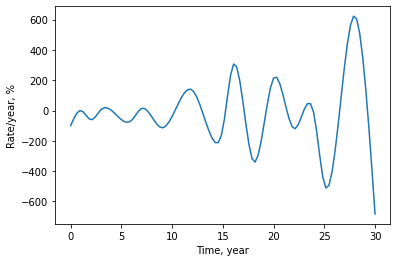

In [21]:
points=100
tmax=30
vx = []
vy1 = []
for i in range(points):
    t = (tmax*i)/(points-1)
    vx.append(t)
    vy1.append(curve(t)/pc)
fig, ax = plt.subplots()
ax.set_xlabel('Time, year')
ax.set_ylabel('Rate/year, %')
ax.plot(vx,vy1,'-')
plt.show()
